In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shap
import warnings
import sys
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import auto_co2 as co2

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.insert(0, '../src/')

file_path = "../data/processed/co2_classification_20240112-161106.pkl"

# Convert the loaded data to a DataFrame
df = pd.read_pickle(file_path)

# **0. Introduction**


In [2]:
co2.styles.display_info(df)
target = df['Co2Grade']
data = df.drop(columns='Co2Grade')

co2.styles.displayer(data)
co2.styles.displayer(pd.DataFrame(target))

,Column,Non-Null Count,Dtype
0,MassRunningOrder,4749 non-null,float64
1,BaseWheel,4749 non-null,float64
2,EnginePower,4749 non-null,float64
3,InnovativeTechnology,4749 non-null,int64
4,ElecRange_NO_RANGE,4749 non-null,int64
5,ElecRange_0to50,4749 non-null,int64
6,ElecRange_50to100,4749 non-null,int64
7,ElecRange_100to150,4749 non-null,int64
8,ElecRange_150+,4749 non-null,int64
9,Pool_BMW,4749 non-null,int64


,Info
0,"Index: 4749 entries, 9871943 to 7877195"
1,Data columns (total 29 columns):
2,28 Co2Grade 4749 non-null category
3,"dtypes: category(1), float64(3), int64(25)"
4,memory usage: 1.1 MB


,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElecRange_NO_RANGE,ElecRange_0to50,ElecRange_50to100,ElecRange_100to150,ElecRange_150+,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_VW-SAIC,FuelType_DIESEL,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC
9871943,1615.000,2829.000,128.000,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4969321,1313.000,2667.000,81.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2183213,1475.000,2612.000,70.000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
17946,1601.000,2629.000,110.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
5989334,1248.000,2417.000,61.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


,Co2Grade
9871943,C
4969321,B
2183213,C
17946,D
5989334,A


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)

# **1. Modèles simples**

## **A. Decision Tree**

In [4]:
%%time
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20)
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
co2.viz.plot_confusion_matrix(y_test, dtc_pred, classes=dtc.classes_, title=': Decision Tree', save=True, format='png')
co2.styles.display_classification_report(y_test, dtc_pred)


,precision,recall,f1-score,support
A,0.982,0.970,0.976,166.000
B,0.825,0.829,0.827,205.000
C,0.844,0.822,0.833,342.000
D,0.796,0.786,0.791,154.000
E,0.726,0.855,0.785,62.000
F,0.700,0.636,0.667,11.000
G,0.750,0.900,0.818,10.000
accuracy,0.844,0.844,0.844,0.844
macro avg,0.803,0.828,0.814,950.000
weighted avg,0.846,0.844,0.845,950.000


CPU times: user 62 ms, sys: 29.9 ms, total: 91.9 ms
Wall time: 461 ms


In [5]:
co2.styles.display_feature_importances(dtc, data)

,importance
MassRunningOrder,0.272
EnginePower,0.230
ElecRange_NO_RANGE,0.174
BaseWheel,0.105
FuelType_ELECTRIC,0.042
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.030
FuelType_PETROL,0.026
InnovativeTechnology,0.023
FuelType_PETROL/ELECTRIC,0.014
Pool_RENAULT-NISSAN-MITSUBISHI,0.014


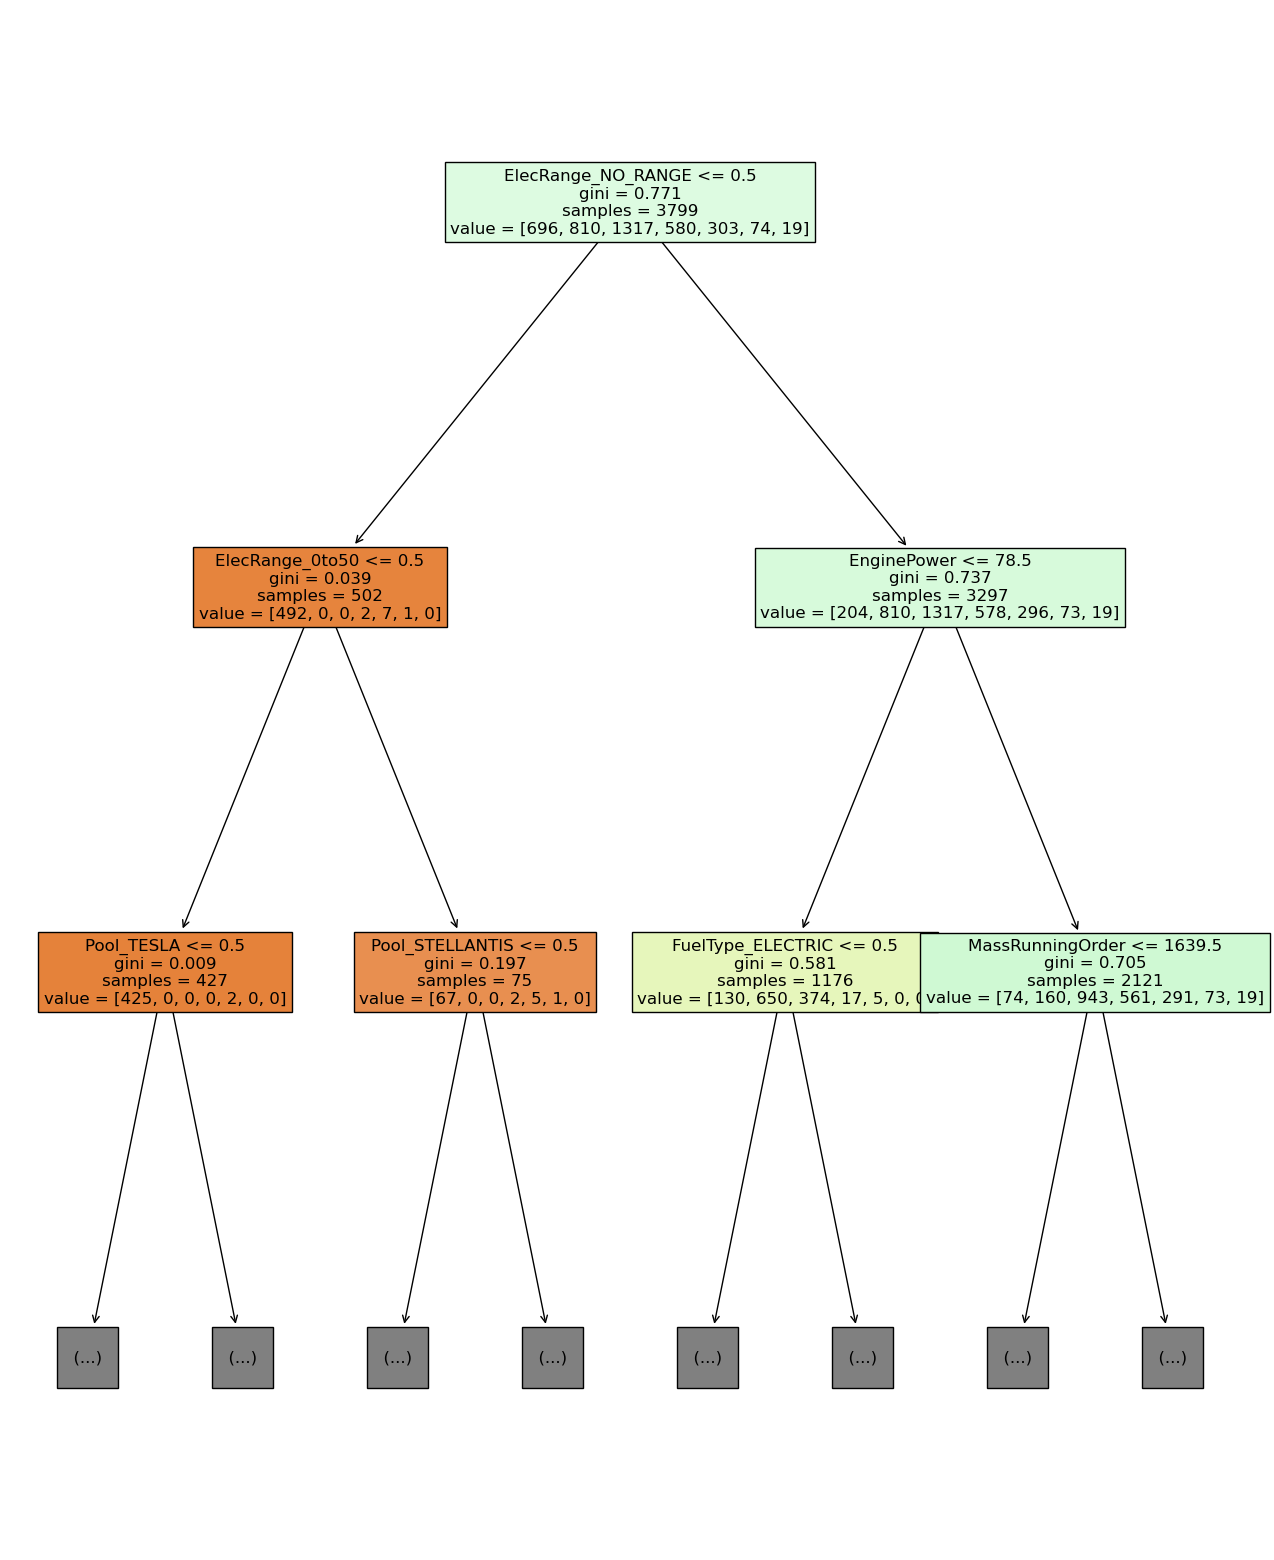

In [6]:
plt.figure(figsize=(16, 20))

plot_tree(dtc, feature_names=X_train.columns.tolist(),
          max_depth=2, filled=True, fontsize=12);

## **B. Random Forest**

In [7]:
%%time
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

co2.viz.plot_confusion_matrix(y_test, rfc_pred, palette='Greens', classes=dtc.classes_, title=': Decision Tree', save=True, format='png')
co2.styles.display_classification_report(y_test, rfc_pred)

,precision,recall,f1-score,support
A,0.982,0.976,0.979,166.000
B,0.876,0.824,0.849,205.000
C,0.857,0.842,0.850,342.000
D,0.783,0.844,0.812,154.000
E,0.768,0.855,0.809,62.000
F,0.667,0.727,0.696,11.000
G,0.889,0.800,0.842,10.000
accuracy,0.861,0.861,0.861,0.861
macro avg,0.832,0.838,0.834,950.000
weighted avg,0.863,0.861,0.862,950.000


CPU times: user 479 ms, sys: 105 ms, total: 584 ms
Wall time: 264 ms


In [8]:
co2.styles.display_feature_importances(rfc, data)

,importance
MassRunningOrder,0.296
EnginePower,0.195
BaseWheel,0.152
FuelType_ELECTRIC,0.059
ElecRange_NO_RANGE,0.058
FuelType_PETROL,0.037
FuelType_DIESEL,0.036
InnovativeTechnology,0.029
FuelType_PETROL/ELECTRIC,0.028
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.020


## **2. Réduction de dimensions**

In [9]:
pca = PCA(n_components=None)
data_pca = pca.fit_transform(data)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, target, test_size=.2, random_state=42)

In [10]:
co2.viz.plot_pca_variance(pca, n_features=5, save=True, format='png')

In [11]:
import plotly.graph_objects as go

# Create the first figure
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(0, len(pca.explained_variance_ratio_))), 
                          y=pca.explained_variance_ratio_, 
                          mode='lines'))
fig1.update_xaxes(range=[0, 5], title_text='Nombre de composantes')
fig1.update_yaxes(title_text='Part de variance expliquée')
fig1.show()

# Create the second figure
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(0, len(pca.explained_variance_ratio_.cumsum()))), 
                          y=pca.explained_variance_ratio_.cumsum(), 
                          mode='lines'))
fig2.add_shape(type="line",
               x0=0, y0=0.9, x1=5, y1=0.9,
               line=dict(color="Red", width=1, dash="dash"))
fig2.update_xaxes(range=[0, 5], title_text='Nombre de composantes')
fig2.update_yaxes(title_text='Part de variance expliquée (cumul)')
fig2.show()

In [12]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Assume X is your feature matrix
pca = PCA(n_components=None)
data_pca = pca.fit_transform(data)

# Create a scatter plot of the explained variance ratio
fig = go.Figure(data=go.Scatter(x=list(range(1, len(pca.explained_variance_ratio_)+1)), 
                                y=pca.explained_variance_ratio_,
                                mode='lines+markers'))

fig.update_layout(title='Explained Variance Ratio by PCA components',
                  xaxis=dict(title='Component'),
                  yaxis=dict(title='Part de la variance expliquée'))

fig.show()

# **3. Modèle d'ensemble: XGBoost**

In [13]:
encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

X_x, X_valid_x, y_x, y_valid_x = train_test_split(data, target_enc, test_size=.1)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=.2, random_state=42)

In [14]:
%%time

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            n_estimators=4, #400
                            num_class=7, 
                            early_stopping_rounds=20, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            n_jobs=-1,
                            verbosity=2)
xgb_clf.fit(X_train_x, y_train_x, eval_set=[(X_train_x, y_train_x), (X_test_x, y_test_x)])

[0]	validation_0-merror:0.20737	validation_0-mlogloss:1.38507	validation_1-merror:0.20819	validation_1-mlogloss:1.39658
[1]	validation_0-merror:0.18865	validation_0-mlogloss:1.13436	validation_1-merror:0.19181	validation_1-mlogloss:1.14955
[2]	validation_0-merror:0.17812	validation_0-mlogloss:0.95084	validation_1-merror:0.18713	validation_1-mlogloss:0.97089
[3]	validation_0-merror:0.17812	validation_0-mlogloss:0.82547	validation_1-merror:0.19181	validation_1-mlogloss:0.85292
CPU times: user 1min 54s, sys: 181 ms, total: 1min 55s
Wall time: 8.16 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=-1, num_class=7, num_parallel_tree=None, ...)

In [15]:
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='merror')
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='mlogloss')

In [16]:
xgb_pred = xgb_clf.predict(X_test_x)
co2.viz.plot_confusion_matrix(y_test_x, xgb_pred, classes=xgb_clf.classes_, palette='Reds')
co2.styles.display_classification_report(y_test_x, xgb_pred)

,precision,recall,f1-score,support
0,0.969,0.987,0.978,158.000
1,0.933,0.732,0.820,190.000
2,0.730,0.877,0.797,284.000
3,0.675,0.612,0.642,129.000
4,0.785,0.699,0.739,73.000
5,0.722,0.765,0.743,17.000
6,1.000,1.000,1.000,4.000
accuracy,0.808,0.808,0.808,0.808
macro avg,0.831,0.810,0.817,855.000
weighted avg,0.817,0.808,0.807,855.000


<Figure size 1600x2000 with 0 Axes>

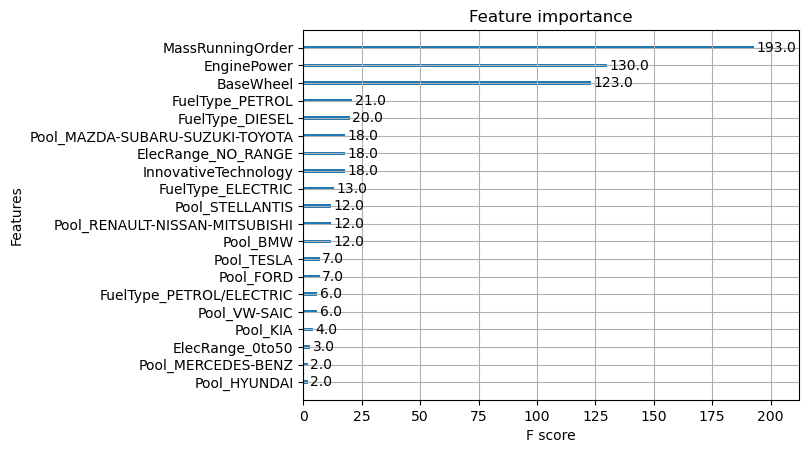

In [17]:
from xgboost import plot_importance
plt.figure(figsize=(16, 20))
plot_importance(xgb_clf, max_num_features=20)   
plt.show()


<Axes: >

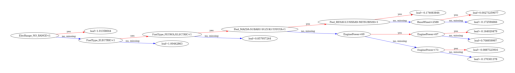

In [18]:
from xgboost import plot_tree
plot_tree(xgb_clf, num_trees=0, rankdir='LR')


In [19]:
co2.viz.plot_feature_importance(xgb_clf)

In [20]:
xgb_valid_pred = xgb_clf.predict(X_valid_x)
co2.viz.plot_confusion_matrix(y_valid_x, xgb_valid_pred, classes=xgb_clf.classes_, palette='Reds')
co2.styles.display_classification_report(y_valid_x, xgb_valid_pred) 


,precision,recall,f1-score,support
0,0.988,0.965,0.976,85.000
1,0.894,0.656,0.756,90.000
2,0.645,0.901,0.751,151.000
3,0.788,0.553,0.650,94.000
4,0.912,0.705,0.795,44.000
5,0.583,1.000,0.737,7.000
6,1.000,0.750,0.857,4.000
accuracy,0.779,0.779,0.779,0.779
macro avg,0.830,0.790,0.789,475.000
weighted avg,0.808,0.779,0.777,475.000


# **3. Interprétabilité des modèles**

In [21]:
%%time
shap_sample = X_test_x.sample(frac=0.2, random_state=42)
explainer = shap.Explainer(xgb_clf.predict, shap_sample)
# Calculates the SHAP values - It takes some time
shap_values = explainer(shap_sample)

PermutationExplainer explainer: 172it [00:26,  4.30it/s]                         

CPU times: user 5min 55s, sys: 476 ms, total: 5min 56s
Wall time: 26.3 s


In [22]:


# Save SHAP values to CSV
shap_values_np = np.concatenate(shap_values, axis=0) if isinstance(shap_values, list) else np.array(shap_values)
shap_values_df = pd.DataFrame(shap_values_np, columns=shap_sample.columns)
shap_values_df.to_csv('shap_values.csv', index=False)

# Save explainer information to CSV
with open('explainer.csv', 'w') as explainer_file:
    explainer_file.write("feature\n")
    explainer_file.write("\n".join(map(str, shap_sample.columns)))

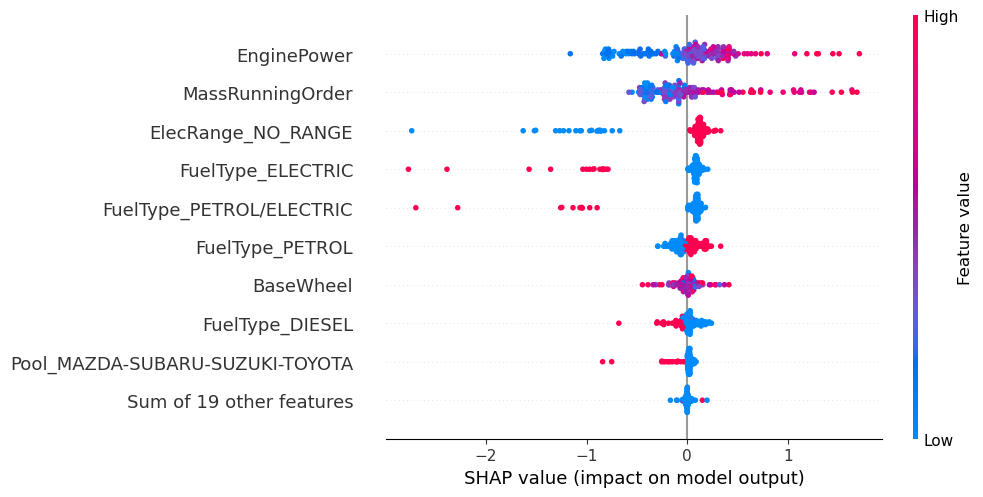

In [23]:
shap.plots.beeswarm(shap_values)

In [24]:
shap.initjs()

shap.plots.force(shap_values[30])

In [25]:
shap.initjs()
shap.plots.force(shap_values[0:300])


In [26]:
#shap.summary_plot(shap_values, X_test_x, plot_type='bar', feature_names=X_test_x.columns)
co2.viz.plot_shap_summary(shap_values, feature_names=X_test_x.columns)

In [27]:
import lime
from lime import lime_tabular

# Create a Lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_x.to_numpy(), 
                                              feature_names=X_train_x.columns, 
                                              class_names=['0', '1'], 
                                              mode='classification')

# Choose a random instance for which to explain the model's prediction
i = np.random.randint(0, X_test_x.shape[0])

# Get the explanation for the prediction
exp = explainer.explain_instance(X_test_x.iloc[i].to_numpy(), xgb_clf.predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)